In [1]:
import pandas as pd
import numpy as np
import nannyml as nml
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from nannyml.drift.multivariate.data_reconstruction.result import Result

In [2]:
df = pd.read_csv('../data/01_raw/house-pricing.csv')

In [3]:
def create_timestamp_column(df, column_name_year, column_name_month):
    df['timestamp'] = pd.to_datetime(df[column_name_year].astype(str) + '-' + df[column_name_month].astype(str), format='%Y-%m')
    
    return df

In [4]:
df = create_timestamp_column(df, column_name_year="YrSold", column_name_month="MoSold")

In [5]:
def filter_rows_by_years(df, years, months=None):
    filtered_df = df[df['timestamp'].dt.year.isin(years)]
    
    if months:
        filtered_df = filtered_df[filtered_df['timestamp'].dt.month.isin(months)]
    
    return filtered_df

In [6]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
important_columns = ["OverallQual", "GrLivArea", "2ndFlrSF", "TotalBsmtSF", "1stFlrSF", "BsmtFinSF1", "YearBuilt", "LotArea", "GarageArea", "GarageCars"]

In [8]:
# filter df by important columns
important_columns.append("timestamp")
df = df[important_columns]
important_columns.remove("timestamp")

In [9]:
# mean_value = df['LotFrontage'].mean()
# df= df.fillna(mean_value)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   OverallQual  1460 non-null   int64         
 1   GrLivArea    1460 non-null   int64         
 2   2ndFlrSF     1460 non-null   int64         
 3   TotalBsmtSF  1460 non-null   int64         
 4   1stFlrSF     1460 non-null   int64         
 5   BsmtFinSF1   1460 non-null   int64         
 6   YearBuilt    1460 non-null   int64         
 7   LotArea      1460 non-null   int64         
 8   GarageArea   1460 non-null   int64         
 9   GarageCars   1460 non-null   int64         
 10  timestamp    1460 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(10)
memory usage: 125.6 KB


In [11]:
reference = filter_rows_by_years(df, [2007, 2008])
analysis = filter_rows_by_years(df, [2009, 2010])

In [12]:
df.describe()

,OverallQual,GrLivArea,2ndFlrSF,TotalBsmtSF,1stFlrSF,BsmtFinSF1,YearBuilt,LotArea,GarageArea,GarageCars
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,346.992466,1057.429452,1162.626712,443.639726,1971.267808,10516.828082,472.980137,1.767123
std,1.382997,525.480383,436.528436,438.705324,386.587738,456.098091,30.202904,9981.264932,213.804841,0.747315
min,1.000000,334.000000,0.000000,0.000000,334.000000,0.000000,1872.000000,1300.000000,0.000000,0.000000
25%,5.000000,1129.500000,0.000000,795.750000,882.000000,0.000000,1954.000000,7553.500000,334.500000,1.000000
50%,6.000000,1464.000000,0.000000,991.500000,1087.000000,383.500000,1973.000000,9478.500000,480.000000,2.000000
75%,7.000000,1776.750000,728.000000,1298.250000,1391.250000,712.250000,2000.000000,11601.500000,576.000000,2.000000
max,10.000000,5642.000000,2065.000000,6110.000000,4692.000000,5644.000000,2010.000000,215245.000000,1418.000000,4.000000


In [13]:
bias = np.random.randint(20, 100, size=len(analysis))

In [14]:
analysis

,OverallQual,GrLivArea,2ndFlrSF,TotalBsmtSF,1stFlrSF,BsmtFinSF1,YearBuilt,LotArea,GarageArea,GarageCars,timestamp
5,5,1362,566,796,796,732,1993,14115,480,2,2009-10-01
7,7,2090,983,1107,1107,859,1973,10382,484,2,2009-11-01
16,6,1004,0,1004,1004,578,1970,11241,480,2,2010-03-01
19,5,1339,0,1029,1339,504,1958,7560,294,1,2009-05-01
24,5,1060,0,1060,1060,188,1968,8246,270,1,2010-05-01
...,...,...,...,...,...,...,...,...,...,...,...
1451,8,1578,0,1573,1578,0,2008,9262,840,3,2009-05-01
1454,7,1221,0,1221,1221,410,2004,7500,400,2,2009-10-01
1456,6,2073,0,1542,2073,790,1978,13175,500,2,2010-02-01
1457,7,2340,1152,1152,1188,275,1941,9042,252,1,2010-05-01


In [15]:
analysis['OverallQual'] = analysis['OverallQual'] + bias

C:\Users\jkick\AppData\Local\Temp\ipykernel_20180\547201236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis['OverallQual'] = analysis['OverallQual'] + bias


In [16]:
analysis

,OverallQual,GrLivArea,2ndFlrSF,TotalBsmtSF,1stFlrSF,BsmtFinSF1,YearBuilt,LotArea,GarageArea,GarageCars,timestamp
5,63,1362,566,796,796,732,1993,14115,480,2,2009-10-01
7,101,2090,983,1107,1107,859,1973,10382,484,2,2009-11-01
16,79,1004,0,1004,1004,578,1970,11241,480,2,2010-03-01
19,93,1339,0,1029,1339,504,1958,7560,294,1,2009-05-01
24,31,1060,0,1060,1060,188,1968,8246,270,1,2010-05-01
...,...,...,...,...,...,...,...,...,...,...,...
1451,71,1578,0,1573,1578,0,2008,9262,840,3,2009-05-01
1454,105,1221,0,1221,1221,410,2004,7500,400,2,2009-10-01
1456,103,2073,0,1542,2073,790,1978,13175,500,2,2010-02-01
1457,62,2340,1152,1152,1188,275,1941,9042,252,1,2010-05-01


In [17]:
def calculate_drift(reference, analysis, feature_column_names):  
    calc = nml.DataReconstructionDriftCalculator(column_names=feature_column_names,
                                                 timestamp_column_name='timestamp'
                                                 )
    calc.fit(reference)

    results = calc.calculate(analysis)

    return results

In [18]:
result_years = calculate_drift(reference, analysis, important_columns)

In [19]:
display(result_years.filter(period='analysis').to_df())

chunk                                                          \
         key chunk_index start_index end_index start_date   end_date   
0     [0:50]           0           0        50 2009-01-01 2009-04-01   
1   [51:101]           1          51       101 2009-04-01 2009-05-01   
2  [102:152]           2         102       152 2009-05-01 2009-06-01   
3  [153:203]           3         153       203 2009-06-01 2009-07-01   
4  [204:254]           4         204       254 2009-07-01 2009-09-01   
5  [255:305]           5         255       305 2009-09-01 2009-11-01   
6  [306:356]           6         306       356 2009-11-01 2010-02-01   
7  [357:407]           7         357       407 2010-02-01 2010-04-01   
8  [408:458]           8         408       458 2010-04-01 2010-05-01   
9  [510:509]           9         459       512 2010-07-01 2010-07-01   

            reconstruction_error                                       \
     period       sampling_error      value upper_confidence_boundary   
0  analysis             0.121452  37.871116                 38.235473   
1  analysis             0.121452  39.760414                 40.124771   
2  analysis             0.121452  39.810893                 40.175249   
3  analysis             0.121452  38.435934                 38.800290   
4  analysis             0.121452  41.114150                 41.478507   
5  analysis             0.121452  42.974059                 43.338415   
6  analysis             0.121452  40.851845                 41.216202   
7  analysis             0.121452  38.514332                 38.878689   
8  analysis             0.121452  43.203569                 43.567926   
9  analysis             0.118030  41.724910                 42.079001   

                                                                   
  lower_confidence_boundary upper_threshold lower_threshold alert  
0                 37.506760        1.609959        1.112769  True  
1                 39.396058        1.609959        1.112769  True  
2                 39.446536        1.609959        1.112769  True  
3                 38.071577        1.609959        1.112769  True  
4                 40.749794        1.609959        1.112769  True  
5                 42.609702        1.609959        1.112769  True  
6                 40.487489        1.609959        1.112769  True  
7                 38.149976        1.609959        1.112769  True  
8                 42.839213        1.609959        1.112769  True  
9                 41.370819        1.609959        1.112769  True

In [26]:
result_years.filter(period='analysis').to_df().to_dict()

{('chunk', 'key'): {0: '[0:50]',
  1: '[51:101]',
  2: '[102:152]',
  3: '[153:203]',
  4: '[204:254]',
  5: '[255:305]',
  6: '[306:356]',
  7: '[357:407]',
  8: '[408:458]',
  9: '[510:509]'},
 ('chunk', 'chunk_index'): {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9},
 ('chunk', 'start_index'): {0: 0,
  1: 51,
  2: 102,
  3: 153,
  4: 204,
  5: 255,
  6: 306,
  7: 357,
  8: 408,
  9: 459},
 ('chunk', 'end_index'): {0: 50,
  1: 101,
  2: 152,
  3: 203,
  4: 254,
  5: 305,
  6: 356,
  7: 407,
  8: 458,
  9: 512},
 ('chunk', 'start_date'): {0: Timestamp('2009-01-01 00:00:00'),
  1: Timestamp('2009-04-01 00:00:00'),
  2: Timestamp('2009-05-01 00:00:00'),
  3: Timestamp('2009-06-01 00:00:00'),
  4: Timestamp('2009-07-01 00:00:00'),
  5: Timestamp('2009-09-01 00:00:00'),
  6: Timestamp('2009-11-01 00:00:00'),
  7: Timestamp('2010-02-01 00:00:00'),
  8: Timestamp('2010-04-01 00:00:00'),
  9: Timestamp('2010-07-01 00:00:00')},
 ('chunk', 'end_date'): {0: Timest

In [20]:
display(result_years.filter(period='reference').to_df())

chunk                                                          \
         key chunk_index start_index end_index start_date   end_date   
0     [0:62]           0           0        62 2007-01-01 2007-04-01   
1   [63:125]           1          63       125 2007-04-01 2007-06-01   
2  [126:188]           2         126       188 2007-06-01 2007-07-01   
3  [189:251]           3         189       251 2007-07-01 2007-08-01   
4  [252:314]           4         252       314 2007-08-01 2007-12-01   
5  [315:377]           5         315       377 2007-12-01 2008-04-01   
6  [378:440]           6         378       440 2008-04-01 2008-06-01   
7  [441:503]           7         441       503 2008-06-01 2008-07-01   
8  [504:566]           8         504       566 2008-07-01 2008-09-01   
9  [630:629]           9         567       632 2008-12-01 2008-12-01   

             reconstruction_error                                      \
      period       sampling_error     value upper_confidence_boundary   
0  reference             0.109275  1.336004                  1.663828   
1  reference             0.109275  1.358735                  1.686559   
2  reference             0.109275  1.522832                  1.850656   
3  reference             0.109275  1.266994                  1.594818   
4  reference             0.109275  1.460746                  1.788571   
5  reference             0.109275  1.363422                  1.691247   
6  reference             0.109275  1.333715                  1.661539   
7  reference             0.109275  1.247187                  1.575011   
8  reference             0.109275  1.430399                  1.758223   
9  reference             0.106762  1.293608                  1.613895   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                  1.008179        1.609959        1.112769  False  
1                  1.030910        1.609959        1.112769  False  
2                  1.195007        1.609959        1.112769  False  
3                  0.939170        1.609959        1.112769  False  
4                  1.132922        1.609959        1.112769  False  
5                  1.035598        1.609959        1.112769  False  
6                  1.005890        1.609959        1.112769  False  
7                  0.919362        1.609959        1.112769  False  
8                  1.102574        1.609959        1.112769  False  
9                  0.973321        1.609959        1.112769  False

In [22]:
figure = result_years.plot()

figure.write_html("../data/08_reporting/figure.html")

In [21]:
# mean_value = df['LotFrontage'].mean()
# df= df.fillna(mean_value)

In [45]:
calc = nml.UnivariateDriftCalculator(

    column_names=important_columns,

    # treat_as_categorical=['binarized'],

    timestamp_column_name='timestamp',

    continuous_methods=['kolmogorov_smirnov', 'jensen_shannon'],

    categorical_methods=['chi2', 'jensen_shannon'],

)

calc.fit(reference)

results = calc.calculate(analysis)


figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')

figure.show()

c:\Users\jkick\.conda\envs\housepricing\lib\site-packages\nannyml\base.py:299: FutureWarning:

The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`



In [46]:
figure = results.filter(column_names=results.categorical_column_names, methods=['chi2']).plot(kind='drift')

figure.show()

ZeroDivisionError: division by zero

In [24]:
prediction = pd.read_csv('../data/07_model_output/df_with_predict.csv')

In [29]:
prediction

,numerical__numerical__MSSubClass,numerical__numerical__LotFrontage,numerical__numerical__LotArea,numerical__numerical__OverallQual,numerical__numerical__OverallCond,numerical__numerical__YearBuilt,numerical__numerical__YearRemodAdd,numerical__numerical__MasVnrArea,numerical__numerical__BsmtFinSF1,numerical__numerical__BsmtFinSF2,...,categorical__categorical__SaleType_New,categorical__categorical__SaleType_Oth,categorical__categorical__SaleType_WD,categorical__categorical__SaleCondition_Abnorml,categorical__categorical__SaleCondition_AdjLand,categorical__categorical__SaleCondition_Alloca,categorical__categorical__SaleCondition_Family,categorical__categorical__SaleCondition_Normal,categorical__categorical__SaleCondition_Partial,y_pred
0,-0.6,-0.018097,-0.288372,0.0,3.0,-0.187500,0.236842,0.000000,0.386269,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,137533.376869
1,0.2,1.455587,0.645797,1.0,0.0,0.458333,0.026316,2.180723,0.898058,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,298351.239230
2,-0.4,-0.754939,-0.155614,-0.5,1.0,-0.937500,-1.157895,0.000000,-0.533287,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,125230.692480
3,0.0,-1.070729,-1.118473,0.0,2.0,-0.520833,-1.157895,0.000000,0.020111,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,150395.898606
4,-0.6,0.981903,0.801897,1.5,0.0,0.729167,0.368421,0.421687,0.884189,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,300085.203762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,-0.4,-1.070729,-0.893563,-1.0,2.0,-0.729167,0.157895,2.620482,-0.300277,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,133248.157745
288,-0.6,2.824008,1.594554,0.5,0.0,0.687500,0.289474,0.096386,1.233703,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,246826.675290
289,0.2,-0.386518,-0.340648,0.5,0.0,0.687500,0.289474,0.000000,0.365465,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,192437.386131
290,0.4,-0.544413,-0.125463,-1.0,0.0,-0.666667,-1.157895,0.000000,-0.533287,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,138356.199480


In [113]:
estimator = nml.DLE(

    feature_column_names=["MSSubClass","MSZoning","LotFrontage","LotArea", "Street"],

    y_pred='binarized',

    y_true='binarized',

    timestamp_column_name='timestamp',

    metrics=['rmse', 'rmsle'],

    tune_hyperparameters=False

)

estimator.fit(reference)

results = estimator.estimate(analysis)

display(results.filter(period='analysis').to_df())

display(results.filter(period='reference').to_df())

metric_fig = results.plot()

metric_fig.show()

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\nannyml\sampling_error\regression.py:191: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\nannyml\sampling_error\regression.py:230: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\nannyml\sampling_error\regression.py:191: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\leoal\.virtualenvs\mlops-nova-project-5FFhJkaC\lib\site-packages\nannyml\sampling_error\regression.py:230: RuntimeWarning:

invalid value encountered in do

chunk                                                          \
         key chunk_index start_index end_index start_date   end_date   
0     [0:50]           0           0        50 2009-01-01 2009-04-01   
1   [51:101]           1          51       101 2009-04-01 2009-05-01   
2  [102:152]           2         102       152 2009-05-01 2009-06-01   
3  [153:203]           3         153       203 2009-06-01 2009-07-01   
4  [204:254]           4         204       254 2009-07-01 2009-09-01   
5  [255:305]           5         255       305 2009-09-01 2009-11-01   
6  [306:356]           6         306       356 2009-11-01 2010-02-01   
7  [357:407]           7         357       407 2010-02-01 2010-04-01   
8  [408:458]           8         408       458 2010-04-01 2010-05-01   
9  [510:509]           9         459       512 2010-07-01 2010-07-01   

                      rmse                 ...                         \
     period sampling_error realized value  ... lower_threshold  alert   
0  analysis            NaN      0.0   0.0  ...             0.0  False   
1  analysis            NaN      0.0   0.0  ...             0.0  False   
2  analysis            NaN      0.0   0.0  ...             0.0  False   
3  analysis            NaN      0.0   0.0  ...             0.0  False   
4  analysis            NaN      0.0   0.0  ...             0.0  False   
5  analysis            NaN      0.0   0.0  ...             0.0  False   
6  analysis            NaN      0.0   0.0  ...             0.0  False   
7  analysis            NaN      0.0   0.0  ...             0.0  False   
8  analysis            NaN      0.0   0.0  ...             0.0  False   
9  analysis            NaN      0.0   0.0  ...             0.0  False   

           rmsle                                           \
  sampling_error realized value upper_confidence_boundary   
0            NaN      0.0   0.0                       NaN   
1            NaN      0.0   0.0                       NaN   
2            NaN      0.0   0.0                       NaN   
3            NaN      0.0   0.0                       NaN   
4            NaN      0.0   0.0                       NaN   
5            NaN      0.0   0.0                       NaN   
6            NaN      0.0   0.0                       NaN   
7            NaN      0.0   0.0                       NaN   
8            NaN      0.0   0.0                       NaN   
9            NaN      0.0   0.0                       NaN   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                       0.0             0.0             0.0  False  
1                       0.0             0.0             0.0  False  
2                       0.0             0.0             0.0  False  
3                       0.0             0.0             0.0  False  
4                       0.0             0.0             0.0  False  
5                       0.0             0.0             0.0  False  
6                       0.0             0.0             0.0  False  
7                       0.0             0.0             0.0  False  
8                       0.0             0.0             0.0  False  
9                       0.0             0.0             0.0  False  

[10 rows x 23 columns]

chunk                                                          \
         key chunk_index start_index end_index start_date   end_date   
0     [0:62]           0           0        62 2007-01-01 2007-04-01   
1   [63:125]           1          63       125 2007-04-01 2007-06-01   
2  [126:188]           2         126       188 2007-06-01 2007-07-01   
3  [189:251]           3         189       251 2007-07-01 2007-08-01   
4  [252:314]           4         252       314 2007-08-01 2007-12-01   
5  [315:377]           5         315       377 2007-12-01 2008-04-01   
6  [378:440]           6         378       440 2008-04-01 2008-06-01   
7  [441:503]           7         441       503 2008-06-01 2008-07-01   
8  [504:566]           8         504       566 2008-07-01 2008-09-01   
9  [630:629]           9         567       632 2008-12-01 2008-12-01   

                       rmse                 ...                         \
      period sampling_error realized value  ... lower_threshold  alert   
0  reference            NaN      0.0   0.0  ...             0.0  False   
1  reference            NaN      0.0   0.0  ...             0.0  False   
2  reference            NaN      0.0   0.0  ...             0.0  False   
3  reference            NaN      0.0   0.0  ...             0.0  False   
4  reference            NaN      0.0   0.0  ...             0.0  False   
5  reference            NaN      0.0   0.0  ...             0.0  False   
6  reference            NaN      0.0   0.0  ...             0.0  False   
7  reference            NaN      0.0   0.0  ...             0.0  False   
8  reference            NaN      0.0   0.0  ...             0.0  False   
9  reference            NaN      0.0   0.0  ...             0.0  False   

           rmsle                                           \
  sampling_error realized value upper_confidence_boundary   
0            NaN      0.0   0.0                       NaN   
1            NaN      0.0   0.0                       NaN   
2            NaN      0.0   0.0                       NaN   
3            NaN      0.0   0.0                       NaN   
4            NaN      0.0   0.0                       NaN   
5            NaN      0.0   0.0                       NaN   
6            NaN      0.0   0.0                       NaN   
7            NaN      0.0   0.0                       NaN   
8            NaN      0.0   0.0                       NaN   
9            NaN      0.0   0.0                       NaN   

                                                                    
  lower_confidence_boundary upper_threshold lower_threshold  alert  
0                       0.0             0.0             0.0  False  
1                       0.0             0.0             0.0  False  
2                       0.0             0.0             0.0  False  
3                       0.0             0.0             0.0  False  
4                       0.0             0.0             0.0  False  
5                       0.0             0.0             0.0  False  
6                       0.0             0.0             0.0  False  
7                       0.0             0.0             0.0  False  
8                       0.0             0.0             0.0  False  
9                       0.0             0.0             0.0  False  

[10 rows x 23 columns]

## Code for PSI from Lab01 

In [114]:
numerical_features = reference.select_dtypes(exclude='object').columns.tolist()
categorical_features = analysis.select_dtypes(include='object').columns.tolist()

In [115]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [116]:
def calculate_psi_categorical(actual, expected):
    actual_perc = actual.value_counts()/len(actual)
    expected_perc = expected.value_counts()/len(expected)
    actual_classes = list(actual_perc.index) 
    expected_classes = list(expected_perc.index)
    PSI = 0
    classes = set(actual_classes + expected_classes)
    for c in classes:
        final_actual_perc = actual_perc[c] if c in actual_classes else 0.00001
        final_expected_perc = expected_perc[c] if c in expected_classes else 0.00001
        PSI += (final_actual_perc - final_expected_perc)*np.log(final_actual_perc/final_expected_perc)
    return PSI

In [122]:
numerical_features = ['MSSubClass', 'LotFrontage', 'LotArea', 'SalePrice', 'binarized', 'proba_pred']

C:\Users\leoal\AppData\Local\Temp\ipykernel_16288\2966103336.py:58: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.



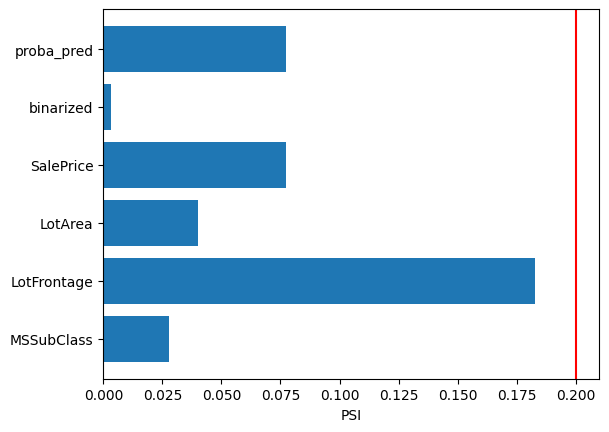

In [123]:
psis_num = []
#Using the github implementation to compute PSI's numerical features
for feature_name in numerical_features:
    psi = calculate_psi(reference[feature_name], analysis[feature_name], buckettype='bins', buckets=20, axis=0)
    psis_num.append(psi)
#Plot each feature's PSI value
height = psis_num
bars = numerical_features
y_pos = np.arange(len(bars))
plt.barh(y_pos, height)
plt.axvline(x=0.2,color='red')
plt.yticks(y_pos, bars)
plt.xlabel("PSI")
plt.show()